## MODELISATION



Ce note book vise à developper les modèles qui aiderons dans la prediction de la consommation d'énergie dans la ville de Seattle. Pour atteindre cet objectif, après importation de la base nettoyé data_cleaned nous allons 
d'abord effectué les opérations de remises à l'échelle (standartisation) sur les variables numériques de notre Data set et tranformer les variables catégorielles à l'aide du One-Hot Encoder ensuite nous ferrons la modélisation proprement dite.
Pour la modelisation nous ferons deux cas :
    . le premier cas consistera à faire la modélisation sans prendre en compte la variable ENERGYSTARScore
    . Le second consistera à prédire la consommation d'energie en introduisant la variable ENERGYSTARScore

## IMPORTATION DES PACKAGES

In [95]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [185]:
import warnings
warnings.filterwarnings('ignore')

In [1]:
# Importation des bibliothèques nécessaires 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Lasso, LassoCV,RidgeCV,Ridge,ElasticNet,ElasticNetCV
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import statsmodels.api as sm
#warnings.filterwarnings('ignore')

In [2]:
%%sh
pwd

Couldn't find program: 'sh'


In [3]:
# Return a new path pointing to the current working directory
HOME_DIR = Path.cwd().parent

# create a variable for data directory
DATA_DIR = Path(HOME_DIR, "machine learning")

print(f"Work directory: {HOME_DIR} \nData directory: {DATA_DIR}")

Work directory: C:\Users\HP\Documents\ISE2_2023_2024 
Data directory: C:\Users\HP\Documents\ISE2_2023_2024\machine learning


Importation de la base nettoyée

In [4]:
data_cleaned = pd.read_csv(Path(DATA_DIR, "data_cleaned.csv"))


### MODELE SANS INSERTION DE LA VARIABLE ENERGIE ENERGYSTARScore 

In [5]:
# Suppression de la variable ENERGYSTARScore
data_cleaned=data_cleaned.drop(["ENERGYSTARScore"],axis=1)

## feature scaling des variables

Les variables de notre jeu de données ayant une très grande échelle, nous allons faire du feature scaling 
(les remettre à l'echelle) pour rendre nos données homogènes. La méthode privilégiée dans notre cas est la 
standardisation car les méthodes (regression) utilisées reposent sur l'hypothèse de normalité.

In [6]:
data_cleaned.columns

Index(['Unnamed: 0', 'OSEBuildingID', 'BuildingType', 'PrimaryPropertyType',
       'Neighborhood', 'YearBuilt', 'NumberofBuildings', 'NumberofFloors',
       'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)',
       'LargestPropertyUseType', 'LargestPropertyUseTypeGFA',
       'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA',
       'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA',
       'SourceEUI(kBtu/sf)', 'SiteEnergyUse(kBtu)', 'SteamUse(kBtu)',
       'Electricity(kBtu)', 'NaturalGas(kBtu)', 'ComplianceStatus', 'Outlier',
       'TotalGHGEmissions', 'GHGEmissionsIntensity', 'NumberOfUse',
       'BuildingAge', 'SiteEnergyUse(log(kBtu))'],
      dtype='object')

In [7]:
col_num = data_cleaned.select_dtypes(['int64','float64']).columns
col_num

Index(['Unnamed: 0', 'OSEBuildingID', 'YearBuilt', 'NumberofBuildings',
       'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
       'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA',
       'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA',
       'SourceEUI(kBtu/sf)', 'SiteEnergyUse(kBtu)', 'SteamUse(kBtu)',
       'Electricity(kBtu)', 'NaturalGas(kBtu)', 'TotalGHGEmissions',
       'GHGEmissionsIntensity', 'NumberOfUse', 'BuildingAge',
       'SiteEnergyUse(log(kBtu))'],
      dtype='object')

In [8]:
Var_cat=data_cleaned.select_dtypes(['object']).columns
Var_cat

Index(['BuildingType', 'PrimaryPropertyType', 'Neighborhood',
       'LargestPropertyUseType', 'SecondLargestPropertyUseType',
       'ThirdLargestPropertyUseType', 'ComplianceStatus', 'Outlier'],
      dtype='object')

selection des variables qualitatives pour la modélisation

In [54]:

var_norm=[ 'NumberofFloors', 'PropertyGFATotal',
       'SourceEUI(kBtu/sf)', 'SteamUse(kBtu)',
       'Electricity(kBtu)', 'NaturalGas(kBtu)', 'TotalGHGEmissions',
       'GHGEmissionsIntensity', 'NumberOfUse', 'BuildingAge',
       'SiteEnergyUse(log(kBtu))']
var_cat=['BuildingType', 'PrimaryPropertyType', 'Neighborhood']

In [55]:
data_cleaned[var_norm].isnull().sum()

NumberofFloors              0
PropertyGFATotal            0
SourceEUI(kBtu/sf)          0
SteamUse(kBtu)              0
Electricity(kBtu)           0
NaturalGas(kBtu)            0
TotalGHGEmissions           0
GHGEmissionsIntensity       0
NumberOfUse                 0
BuildingAge                 0
SiteEnergyUse(log(kBtu))    0
dtype: int64

In [56]:
data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1295 entries, 0 to 1294
Data columns (total 29 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Unnamed: 0                       1295 non-null   int64  
 1   OSEBuildingID                    1295 non-null   int64  
 2   BuildingType                     1295 non-null   object 
 3   PrimaryPropertyType              1295 non-null   object 
 4   Neighborhood                     1295 non-null   object 
 5   YearBuilt                        1295 non-null   int64  
 6   NumberofBuildings                1295 non-null   float64
 7   NumberofFloors                   1295 non-null   int64  
 8   PropertyGFATotal                 1295 non-null   int64  
 9   PropertyGFAParking               1295 non-null   int64  
 10  PropertyGFABuilding(s)           1295 non-null   int64  
 11  LargestPropertyUseType           1295 non-null   object 
 12  LargestPropertyUseTy

In [58]:
data_mod=data_cleaned[['NumberofFloors', 'PropertyGFATotal',
       'SourceEUI(kBtu/sf)', 'SteamUse(kBtu)',
       'Electricity(kBtu)', 'NaturalGas(kBtu)', 'TotalGHGEmissions',
       'GHGEmissionsIntensity', 'NumberOfUse', 'BuildingAge',
       'SiteEnergyUse(log(kBtu))','BuildingType', 'PrimaryPropertyType', 'Neighborhood']]

In [59]:
data_mod

,NumberofFloors,PropertyGFATotal,SourceEUI(kBtu/sf),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity,NumberOfUse,BuildingAge,SiteEnergyUse(log(kBtu)),BuildingType,PrimaryPropertyType,Neighborhood
0,12,88434,182.500000,2003882.00,3.946027e+06,1.276453e+06,249.98,2.83,1,89,15.793246,NonResidential,Hotel,Downtown
1,11,103566,176.100006,0.00,3.242851e+06,5.145082e+06,295.86,2.86,3,20,15.942305,NonResidential,Hotel,Downtown
2,41,956110,241.899994,21566554.00,4.952666e+07,1.493800e+06,2089.28,2.19,1,47,18.100297,NonResidential,Hotel,Downtown
3,10,61320,216.199997,2214446.25,2.768924e+06,1.811213e+06,286.43,4.67,1,90,15.731636,NonResidential,Hotel,Downtown
4,2,97288,316.299988,0.00,7.371434e+06,4.715182e+06,301.81,3.10,1,17,16.307609,Nonresidential COS,Other,Downtown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1290,1,12294,161.699997,0.00,5.242709e+05,3.254750e+05,20.94,1.70,1,26,13.652692,Nonresidential COS,Office,Greater duwamish
1291,1,16000,114.199997,0.00,3.965461e+05,5.537300e+05,32.17,2.01,1,12,13.764508,Nonresidential COS,Other,Downtown
1292,1,13157,744.799988,0.00,1.792159e+06,3.973739e+06,223.54,16.99,3,42,15.567471,Nonresidential COS,Other,Magnolia / queen anne
1293,1,14101,105.300003,0.00,3.488702e+05,3.706010e+05,22.11,1.57,5,27,13.486272,Nonresidential COS,Mixed Use Property,Greater duwamish



Nous allons appliquer le logarithme des variables présentes dans le vecteur var_log 
ceci par soucis de remise à l'échelle et dans le but de normaliser ses variables.

In [60]:
# standardisation des variables numériques
data_mod[var_norm] = StandardScaler().fit_transform(data_mod[var_norm])

C:\Users\HP\AppData\Local\Temp\ipykernel_3368\2568595305.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_mod[var_norm] = StandardScaler().fit_transform(data_mod[var_norm])


Verification de la normalisation des variables numériques

In [61]:
def verification_normalisation(data_mod):
      for variable_norm in data_mod :
        data_mod_col=data_mod[variable_norm]
        moyenne=np.mean(data_mod_col)
        ecartType = np.std(data_mod_col)

        print("les statistiques pour la variable {}" .format(variable_norm))
        print("La moyenne est de : {} ".format(round(abs(moyenne), 2)))
        print("L'écart type est de : {} ".format(round(abs(ecartType), 2)))
        print(" ")
        print(" ")

In [62]:
verification_normalisation(data_cleaned[var_norm])

les statistiques pour la variable NumberofFloors
La moyenne est de : 3.95 
L'écart type est de : 5.78 
 
 
les statistiques pour la variable PropertyGFATotal
La moyenne est de : 103290.88 
L'écart type est de : 166453.93 
 
 
les statistiques pour la variable SourceEUI(kBtu/sf)
La moyenne est de : 176.02 
L'écart type est de : 192.5 
 
 
les statistiques pour la variable SteamUse(kBtu)
La moyenne est de : 229709.87 
L'écart type est de : 1697274.9 
 
 
les statistiques pour la variable Electricity(kBtu)
La moyenne est de : 4744775.7 
L'écart type est de : 11593851.39 
 
 
les statistiques pour la variable NaturalGas(kBtu)
La moyenne est de : 1572526.2 
L'écart type est de : 5097237.9 
 
 
les statistiques pour la variable TotalGHGEmissions
La moyenne est de : 134.33 
L'écart type est de : 338.36 
 
 
les statistiques pour la variable GHGEmissionsIntensity
La moyenne est de : 1.5 
L'écart type est de : 2.02 
 
 
les statistiques pour la variable NumberOfUse
La moyenne est de : 1.81 
L'é


Commentaire: Les variables ont bien été standartisée car chacune d'elle à une moyenne de zéro et
un écart-type de 1.

In [63]:
# affichage de l'entête de la base de donnée après normalisation des varibles
data_mod.head()

,NumberofFloors,PropertyGFATotal,SourceEUI(kBtu/sf),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity,NumberOfUse,BuildingAge,SiteEnergyUse(log(kBtu)),BuildingType,PrimaryPropertyType,Neighborhood
0,1.391058,-0.089255,0.033681,1.045306,-0.068894,-0.058085,0.341808,0.659356,-0.657886,1.003184,0.760770,NonResidential,Hotel,Downtown
1,1.218161,0.001653,0.000434,-0.135340,-0.129545,0.700881,0.477402,0.674224,0.966446,-1.078213,0.878490,NonResidential,Hotel,Downtown
2,6.405090,5.123454,0.342247,12.571236,3.862555,-0.015445,5.777713,0.342162,-0.657886,-0.263753,2.582787,NonResidential,Hotel,Downtown
3,1.045263,-0.252147,0.208742,1.169366,-0.170422,0.046827,0.449533,1.571287,-0.657886,1.033349,0.712113,NonResidential,Hotel,Downtown
4,-0.337918,-0.036063,0.728733,-0.135340,0.226556,0.616541,0.494987,0.793172,-0.657886,-1.168708,1.166993,Nonresidential COS,Other,Downtown


In [64]:

# vérification des valeurs manquantes sur les varibles quantitatives de notre dataset
data_mod[var_norm].isnull().sum()

NumberofFloors              0
PropertyGFATotal            0
SourceEUI(kBtu/sf)          0
SteamUse(kBtu)              0
Electricity(kBtu)           0
NaturalGas(kBtu)            0
TotalGHGEmissions           0
GHGEmissionsIntensity       0
NumberOfUse                 0
BuildingAge                 0
SiteEnergyUse(log(kBtu))    0
dtype: int64

## ENCODAGE DES VARIABLES CATEGORIELLES


Les modèles de machine Learning qui seront dévéloppés étant les modèles de regression, il est impératif de transformer les variables catégorielles de notre data set en variables numériques "quantitatives" (car se ne sont pas réellement les variables numériques) pour que le modèle puisse fonctionné Car ces modèles ne prennent en compte que les varibles numériques voire quantitative.

pour l'encodage des variables categorielles la methode utilisée sera celle du One-Hot Encoding qui consiste à diviser une variable catégorielle en N variables où chaque nouvelle variable correspond à une modalité prise par la variable catégorielle. Chaque variable créée est codée en 0 ou 1 selon la présence ou l'absence de cette modalité pour la ligne.

Le choix du One-Hot Encoding se justifie par le fait qu'il ne prend pas en compte l'ordre qui existe entre les variables et qu'on peut interprété les variables comme categorielles en calculant les proportions.


In [65]:
# reccupération des variables Catégorielles
col_cat = data_mod.select_dtypes(['object']).columns

In [66]:

# affichage de l'entête de la base de donnée pour les variables categorielles
data_mod[col_cat].head()

,BuildingType,PrimaryPropertyType,Neighborhood
0,NonResidential,Hotel,Downtown
1,NonResidential,Hotel,Downtown
2,NonResidential,Hotel,Downtown
3,NonResidential,Hotel,Downtown
4,Nonresidential COS,Other,Downtown


#### Affichage du nombre de modalités pour chaque variables catégorielles

In [67]:
data_mod["BuildingType"].unique().shape

(5,)

In [68]:
data_mod["PrimaryPropertyType"].unique().shape

(17,)

In [69]:
data_mod["Neighborhood"].unique().shape

(13,)

In [70]:
data_cleaned["Outlier"].unique().shape

(3,)

In [71]:
col_num = data_mod.select_dtypes(['int64','float64']).columns

In [72]:
 #Création d'une instance one-hot-encoder
encoder = OneHotEncoder(handle_unknown='ignore')

# Effectuer un one-hot encoding sur les colonnes 'col_cat'
data_ohe = pd.DataFrame(encoder.fit_transform(data_mod[col_cat]).toarray())

# Obtenez les noms des caractéristiques pour les colonnes one-hot encodées
feature_names = encoder.get_feature_names_out(input_features=col_cat)
data_ohe.columns = feature_names

# Fusionner les colonnes one-hot encoded avec le DataFrame d'origine
data_mod_encode = pd.merge(data_mod[col_num].reset_index(), data_ohe, left_index=True, right_index=True)

In [73]:
data_mod_encode

,index,NumberofFloors,PropertyGFATotal,SourceEUI(kBtu/sf),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity,NumberOfUse,...,Neighborhood_Downtown,Neighborhood_East,Neighborhood_Greater duwamish,Neighborhood_Lake union,Neighborhood_Magnolia / queen anne,Neighborhood_North,Neighborhood_Northeast,Neighborhood_Northwest,Neighborhood_Southeast,Neighborhood_Southwest
0,0,1.391058,-0.089255,0.033681,1.045306,-0.068894,-0.058085,0.341808,0.659356,-0.657886,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,1.218161,0.001653,0.000434,-0.135340,-0.129545,0.700881,0.477402,0.674224,0.966446,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,6.405090,5.123454,0.342247,12.571236,3.862555,-0.015445,5.777713,0.342162,-0.657886,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,1.045263,-0.252147,0.208742,1.169366,-0.170422,0.046827,0.449533,1.571287,-0.657886,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,-0.337918,-0.036063,0.728733,-0.135340,0.226556,0.616541,0.494987,0.793172,-0.657886,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1290,1290,-0.510816,-0.546679,-0.074369,-0.135340,-0.364030,-0.244652,-0.335102,0.099311,-0.657886,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1291,1291,-0.510816,-0.524415,-0.321118,-0.135340,-0.375046,-0.199872,-0.301913,0.252951,-0.657886,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1292,1292,-0.510816,-0.541494,2.954668,-0.135340,-0.254671,0.471081,0.263666,7.677265,0.966446,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1293,1293,-0.510816,-0.535823,-0.367351,-0.135340,-0.379158,-0.235799,-0.331644,0.034881,2.590779,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [74]:
## affichage du nom des colonnes du nouveau de la nouvelle base
data_mod_encode.columns

Index(['index', 'NumberofFloors', 'PropertyGFATotal', 'SourceEUI(kBtu/sf)',
       'SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)',
       'TotalGHGEmissions', 'GHGEmissionsIntensity', 'NumberOfUse',
       'BuildingAge', 'SiteEnergyUse(log(kBtu))', 'BuildingType_Campus',
       'BuildingType_NonResidential', 'BuildingType_Nonresidential COS',
       'BuildingType_Nonresidential WA', 'BuildingType_SPS-District K-12',
       'PrimaryPropertyType_Distribution Center',
       'PrimaryPropertyType_Education', 'PrimaryPropertyType_Hospital',
       'PrimaryPropertyType_Hotel', 'PrimaryPropertyType_Laboratory',
       'PrimaryPropertyType_Medical Office',
       'PrimaryPropertyType_Mixed Use Property', 'PrimaryPropertyType_Office',
       'PrimaryPropertyType_Other', 'PrimaryPropertyType_Residence Hall',
       'PrimaryPropertyType_Restaurant', 'PrimaryPropertyType_Retail Store',
       'PrimaryPropertyType_Self-Storage Facility',
       'PrimaryPropertyType_Senior Care Community'

## CHOIX DU MODELE DE REGRESSION

Nous allons tester 4 algorithmes de regression à savoir:
    . L'algorithme de regression linéaire
    . L'algorithme Linear_SVR
    . L'algorithme de RandomForest Regressor
    . L'algorithme XGBoost
  
Cela se fera sans optimisation des hyperparamètres et sera appliquer à la consommations d'énergies  et on va garder l'algorithme de regression qui donne les meilleurs scores pour l'appliquer aux prédictions.

 comme technique de validation croisée nous allons utiliser la méthode du Traint test split car 
 ayant un jeu de donnée à Plus de 1000 observations, elle sera éfficace et rapide pour l'évaluation du modèle.

## Variable 'SiteEnergyUse(kBtu)'

### Division des données en train et en test
pour notre cas nous attribuerons 80% de nos données entrainnement et 20% pour le test
dans le but d'éviter que les resultats de nos prédictions soient du au hasard, nous ferrons usage de la fonction "random_state = 42" d'enlever les effets de l'aléa et pour permettre la reproductibilité de nos modèles.

In [75]:
# Division les données de data_cleaned_encode en ensembles d'apprentissage et de test

train, test = train_test_split(data_mod_encode, test_size=0.2, random_state=42)
print("Entrainement: {} lignes,\nTest: {} lignes.\n".format(train.shape[0],
                                                            test.shape[0]))


Entrainement: 1036 lignes,
Test: 259 lignes.



### selection des features sur la base de train
pour selectionner les variables du modèle nous allons nous appesentir uniquement sur la base de Train afin d'être 
assurer de l'indépendance entre les données du test et ceux de l'entrainnement

In [76]:
#resumé statistique des variables de la base de train
train.describe()

,index,NumberofFloors,PropertyGFATotal,SourceEUI(kBtu/sf),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity,NumberOfUse,...,Neighborhood_Downtown,Neighborhood_East,Neighborhood_Greater duwamish,Neighborhood_Lake union,Neighborhood_Magnolia / queen anne,Neighborhood_North,Neighborhood_Northeast,Neighborhood_Northwest,Neighborhood_Southeast,Neighborhood_Southwest
count,1036.000000,1036.000000,1036.000000,1036.000000,1036.000000,1036.000000,1036.000000,1036.000000,1036.000000,1036.000000,...,1036.000000,1036.000000,1036.000000,1036.000000,1036.000000,1036.000000,1036.000000,1036.000000,1036.000000,1036.000000
mean,646.649614,-0.003805,-0.004747,-0.003910,0.003785,-0.016431,0.001967,-0.000886,-0.005156,-0.007996,...,0.238417,0.074324,0.212355,0.083012,0.091699,0.039575,0.074324,0.042471,0.026062,0.025097
std,373.699714,0.960705,0.971517,1.004831,1.058178,0.769227,1.023147,1.022650,1.008337,0.942432,...,0.426321,0.262425,0.409172,0.276033,0.288740,0.195053,0.262425,0.201759,0.159396,0.156494
min,0.000000,-0.510816,-0.543825,-0.898770,-0.135340,-0.409249,-0.308506,-0.396486,-0.743235,-0.657886,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,322.750000,-0.510816,-0.446075,-0.524751,-0.135340,-0.349968,-0.308506,-0.338212,-0.574726,-0.657886,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,645.500000,-0.337918,-0.321884,-0.235146,-0.135340,-0.278552,-0.211931,-0.257448,-0.326918,-0.657886,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,972.250000,0.007877,-0.001748,0.123030,-0.135340,-0.032108,-0.021142,-0.017461,0.160023,0.154280,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1294.000000,12.456508,11.107753,12.695794,18.147022,9.565107,26.802499,23.676451,11.999028,5.839444,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


IndexError: index 20 is out of bounds for axis 0 with size 20

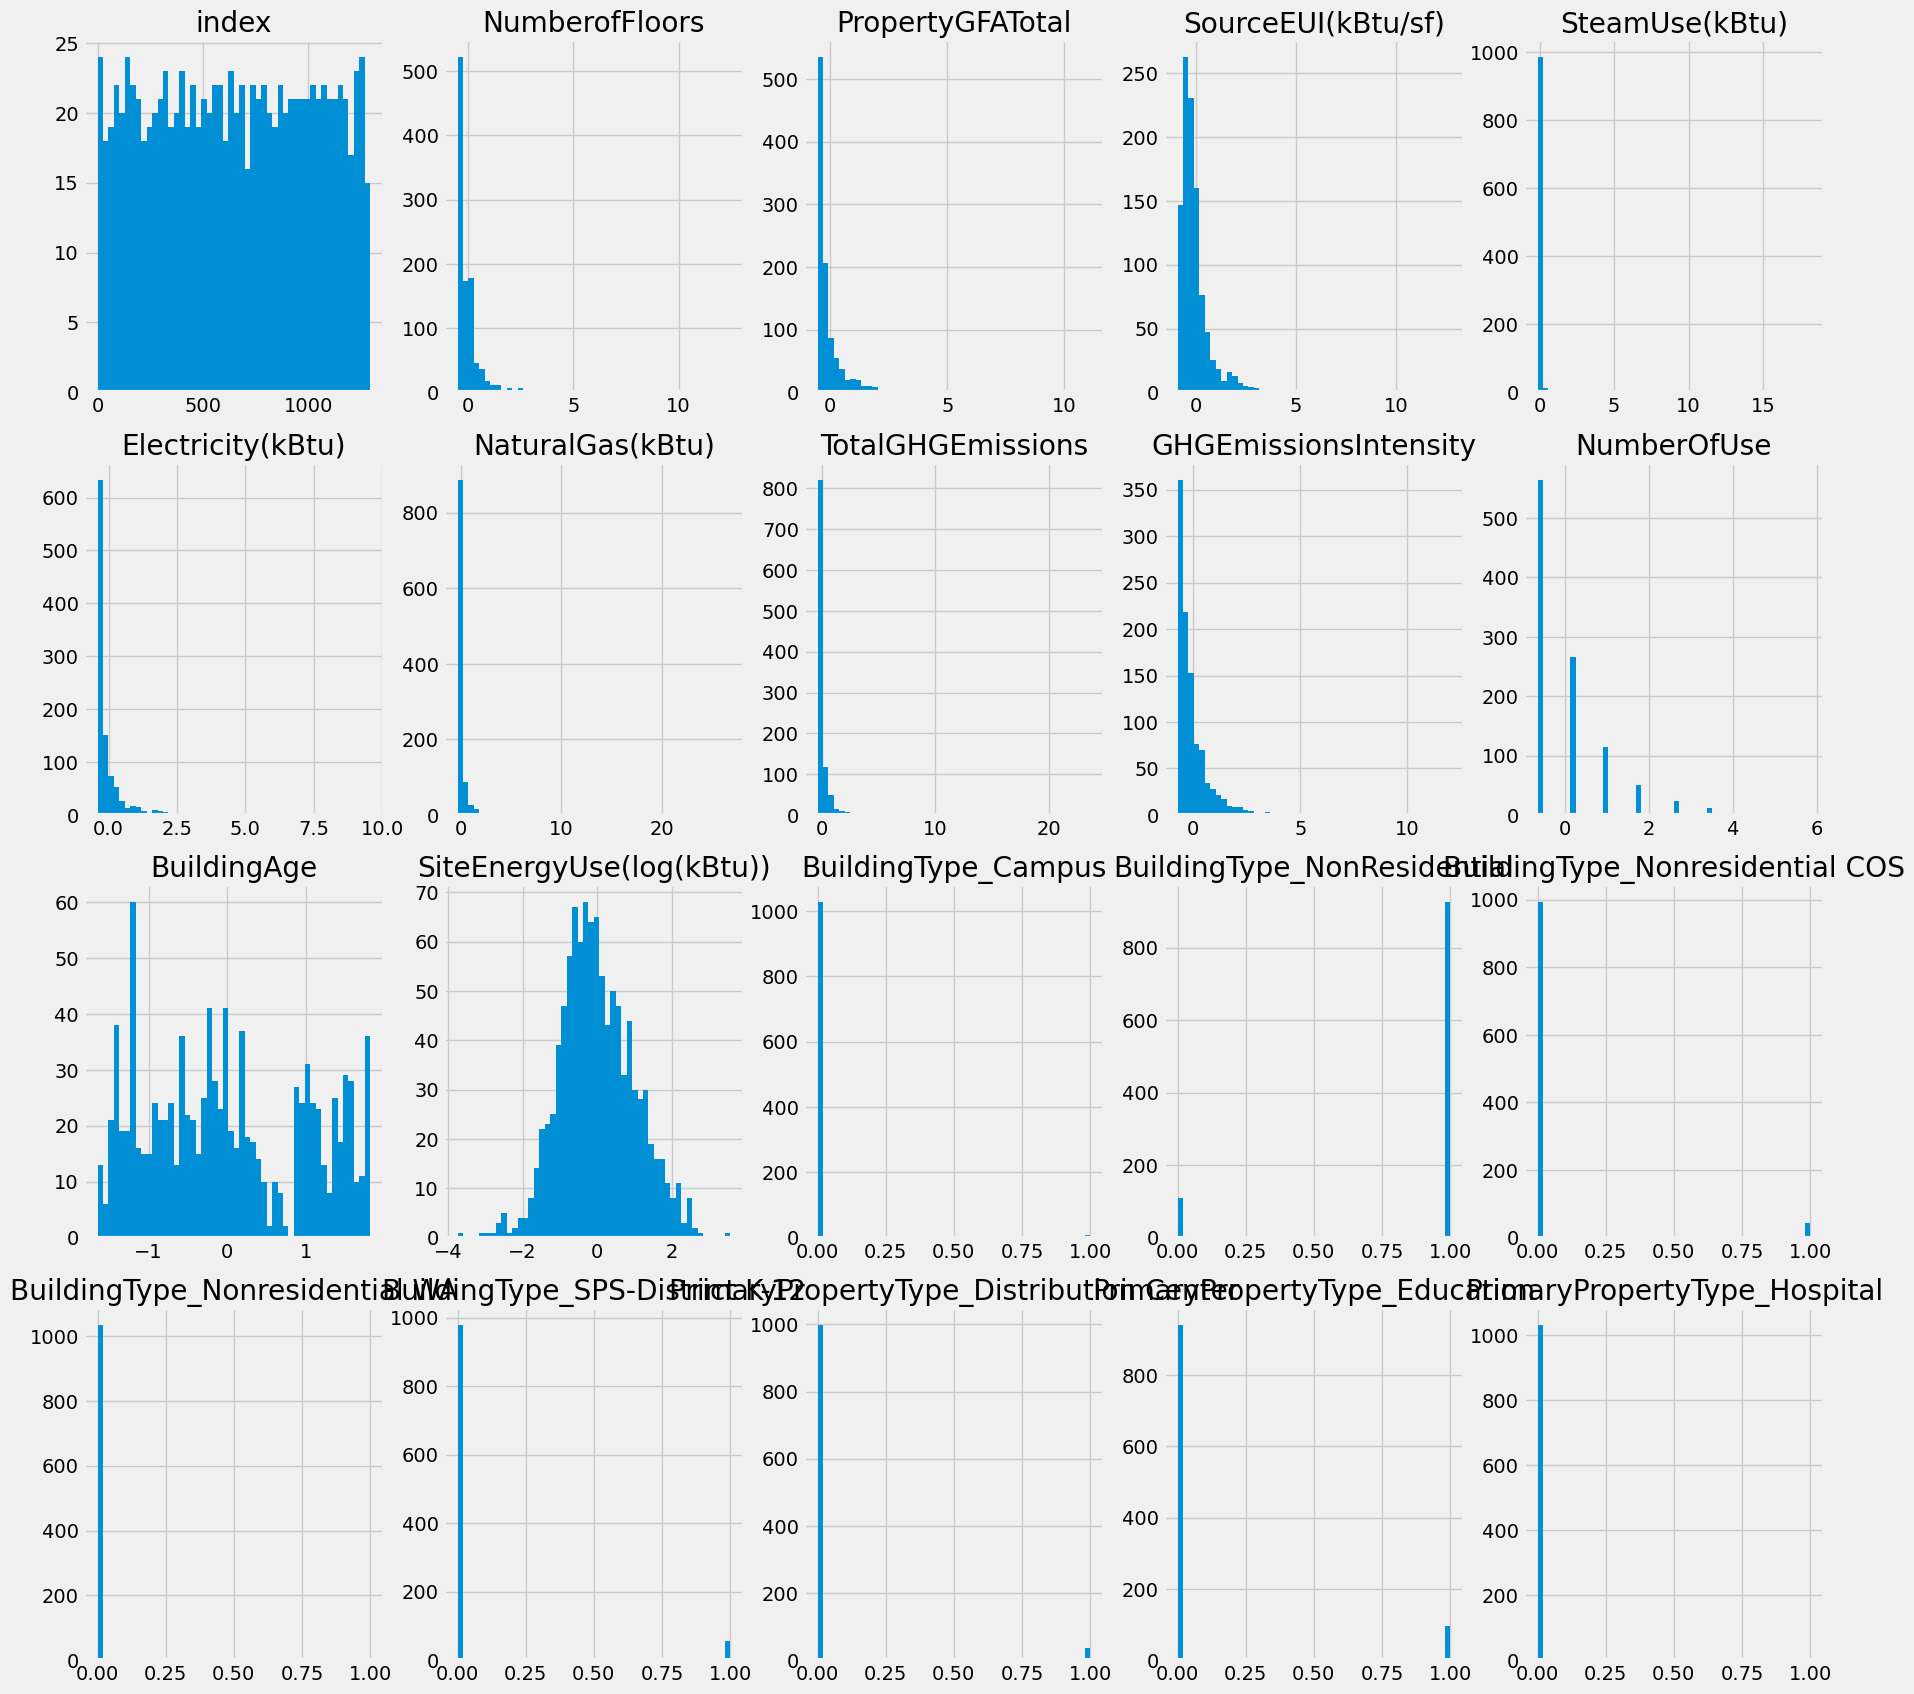

In [77]:
# Visualisation de la distribution des variables
fig, axs = plt.subplots(4, 5, figsize=(20, 20))
axs = axs.ravel()

for i, column in enumerate(train.columns):
    axs[i].hist(train[column], bins=50)
    axs[i].set_title(column)

plt.show()

In [ ]:

# affichage des boxplot pour chaque variables numériques de la partie destinée à l'entrainement

num_cols = list(train.select_dtypes(include=["float64", "int64"]).columns)

for col in num_cols:
    plt.figure(figsize=(6, 4))
    sns.boxplot(data=train, y=col, color="blue")
    plt.title(f"Boxplot de {col}")
    plt.ylabel(col)
    plt.show()

In [ ]:
# Affichage des nuages de points entre la variable d'intérêt et toutes les autres variables 
target_col = "SiteEnergyUse(kBtu)"
num_cols = list(train.select_dtypes(include=["float64", "int64"]).columns)
num_cols.remove(target_col)

for col in num_cols:
    plt.figure(figsize=(6, 4))
    sns.scatterplot(data=train, x=col, y=target_col, color="blue")
    plt.title(f"Nuage de points entre {col} et {target_col}")
    plt.xlabel(col)
    plt.ylabel(target_col)
    plt.show()

### Selection des variables à partir de la correlation de pearson


In [ ]:

# Calcul de la corrélation entre chaque variable et la variable cible (en valeur absolue)
correlations = abs(train.corr()["SiteEnergyUselog((kBtu))"]).sort_values(ascending=False)

# Représentation graphique des corrélations
plt.figure(figsize=(12, 6))
sns.barplot(x=correlations.values, y=correlations.index)
plt.xlabel("Valeur absolue de la corrélation")
plt.ylabel("Variable")
plt.title("Corrélation de chaque variable avec la valeur médiane des maisons")
plt.show()

## MODELISATION SUR LA BASE TRAIN

In [78]:
lr = LinearRegression()
lsvr = LinearSVR(random_state=42, tol=1e-05)
clf = RandomForestRegressor(max_depth=2, random_state=42)
import xgboost as xgb
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor

# Utilisez un autre nom de variable pour le modèle XGBRegressor
xgb = xgb.XGBRegressor(objective="reg:linear", random_state=42)


xgb = XGBRegressor(max_depth=2,random_state=42)

### 1. Modèle de Regression Lineaire

In [79]:
import statsmodels.api as sm
# Séparation des variables prédictives et de la variable cible
X_train = train.drop("SiteEnergyUse(log(kBtu))", axis=1)
y_train = train["SiteEnergyUse(log(kBtu))"]


X_test = test.drop("SiteEnergyUse(log(kBtu))", axis=1)
y_test = test["SiteEnergyUse(log(kBtu))"]

# Fit du modèle linéaire
lr_model = sm.OLS(y_train, sm.add_constant(X_train)).fit()

# Obtention du tableau de résultats
results_table = lr_model.summary2().tables[1]
results_table

,Coef.,Std.Err.,t,P>|t|,[0.025,0.975]
const,0.398366,0.094059,4.235271,2.495015e-05,0.213788,0.582943
index,-0.000531,0.000048,-11.176473,2.127972e-27,-0.000624,-0.000438
NumberofFloors,-0.026434,0.028828,-0.916982,3.593749e-01,-0.083004,0.030136
PropertyGFATotal,0.394273,0.036435,10.821278,7.119762e-26,0.322774,0.465771
SourceEUI(kBtu/sf),0.289844,0.030369,9.544068,1.030067e-20,0.230249,0.349439
SteamUse(kBtu),405.352762,709.554870,0.571278,5.679409e-01,-987.048096,1797.753620
Electricity(kBtu),250.139037,437.758556,0.571409,5.678521e-01,-608.900079,1109.178153
NaturalGas(kBtu),837.591864,1466.209398,0.571263,5.679505e-01,-2039.636255,3714.819983
TotalGHGEmissions,-1046.831014,1832.591884,-0.571230,5.679733e-01,-4643.032831,2549.370803
GHGEmissionsIntensity,0.216685,0.025288,8.568790,3.956481e-17,0.167061,0.266308


In [80]:
lr.fit(X_train, y_train)
y_lr_pred = lr.predict(X_test)
print("RMSE: %.2f" % np.sqrt(mean_squared_error(y_test, y_lr_pred)))
print("Coefficient of determination (R²): %.2f"% r2_score(y_test, y_lr_pred))

RMSE: 0.51
Coefficient of determination (R²): 0.75


les variables utilisés sont significatives au seuil 15%

In [81]:
lr_model.summary2().tables[0]

,0,1,2,3
0,Model:,OLS,Adj. R-squared:,0.751
1,Dependent Variable:,SiteEnergyUse(log(kBtu)),AIC:,1533.8618
2,Date:,2024-02-05 23:44,BIC:,1751.3592
3,No. Observations:,1036,Log-Likelihood:,-722.93
4,Df Model:,43,F-statistic:,73.66
5,Df Residuals:,992,Prob (F-statistic):,1.60e-275
6,R-squared:,0.762,Scale:,0.24688


In [82]:
from sklearn.metrics import (mean_absolute_error, mean_absolute_percentage_error
                             ,max_error, mean_squared_log_error)

In [83]:
print("RMSE: %.2f" % np.sqrt(mean_squared_error(y_test,  y_lr_pred)))

RMSE: 0.51


In [84]:
#plt.title("LinearRegression - SiteEnergyUseWN(kBtu)")
#plt.scatter(y_test,X_test , color='coral')
#plt.xlabel("Vraies valeurs")
#plt.ylabel("Valeurs prédictes")

Definition des modèles LinearSVR, RandomForestRegressor et XGBRegressor

In [85]:
lr = LinearRegression()
lsvr = LinearSVR(random_state=42, tol=1e-05)
clf = RandomForestRegressor(max_depth=2, random_state=42)
import xgboost as xgb
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor

# Utilisez un autre nom de variable pour le modèle XGBRegressor
xgb = xgb.XGBRegressor(objective="reg:linear", random_state=42)


xgb = XGBRegressor(max_depth=2,random_state=42)

## 2. Algorithme LinearSVR

In [86]:
lsvr.fit(X_train, y_train)
y_lsvr_pred = lsvr.predict(X_test)
print("RMSE: %.2f" % np.sqrt(mean_squared_error(y_test, y_lsvr_pred)))
print("Coefficient of determination (R²): %.2f"% r2_score(y_test, y_lsvr_pred))

RMSE: 0.68
Coefficient of determination (R²): 0.55


C:\Users\HP\anaconda3\lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\HP\anaconda3\lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Text(0, 0.5, 'Valeurs prédictes')

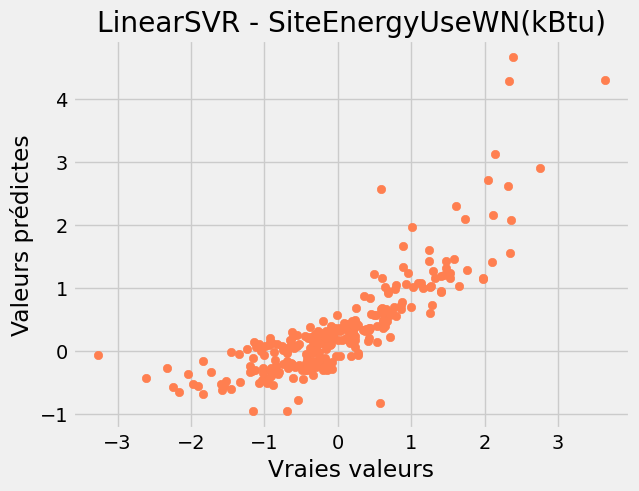

In [87]:
plt.title("LinearSVR - SiteEnergyUseWN(kBtu)")
plt.scatter(y_test, y_lsvr_pred, color='coral')
plt.xlabel("Vraies valeurs")
plt.ylabel("Valeurs prédictes")

## 3. Algorithme RandomForestRegressor

In [88]:
clf.fit(X_train, y_train)
y_rdf_pred = clf.predict(X_test)
print("RMSE: %.2f" % np.sqrt(mean_squared_error(y_test, y_rdf_pred)))
print("Coefficient of determination (R²): %.2f"% r2_score(y_test, y_rdf_pred))

RMSE: 0.40
Coefficient of determination (R²): 0.84


Text(0, 0.5, 'Valeurs prédictes')

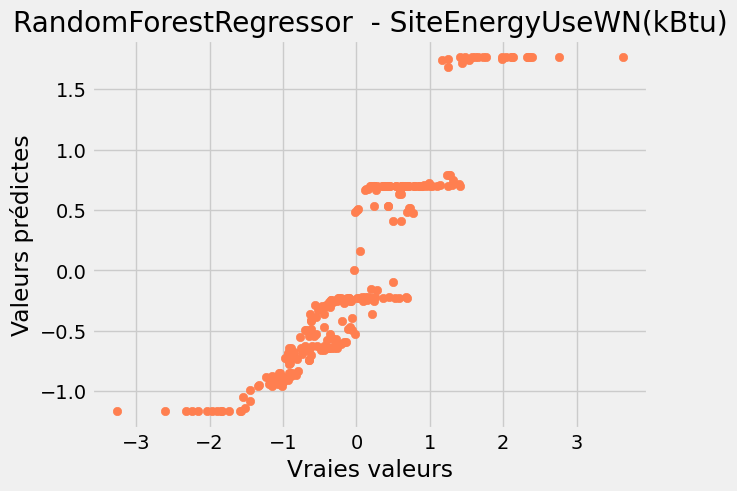

In [89]:
plt.title("RandomForestRegressor  - SiteEnergyUseWN(kBtu)")
plt.scatter(y_test, y_rdf_pred, color='coral')
plt.xlabel("Vraies valeurs")
plt.ylabel("Valeurs prédictes")

## 4.Algorithme XGBoost

In [90]:
xgb.fit(X_train, y_train)
y_xgb_pred = xgb.predict(X_test)
print("RMSE: %.2f" % np.sqrt(mean_squared_error(y_test, y_xgb_pred)))
print("Coefficient of determination (R²): %.2f"% r2_score(y_test, y_xgb_pred))

RMSE: 0.08
Coefficient of determination (R²): 0.99


Text(0, 0.5, 'Valeurs prédictes')

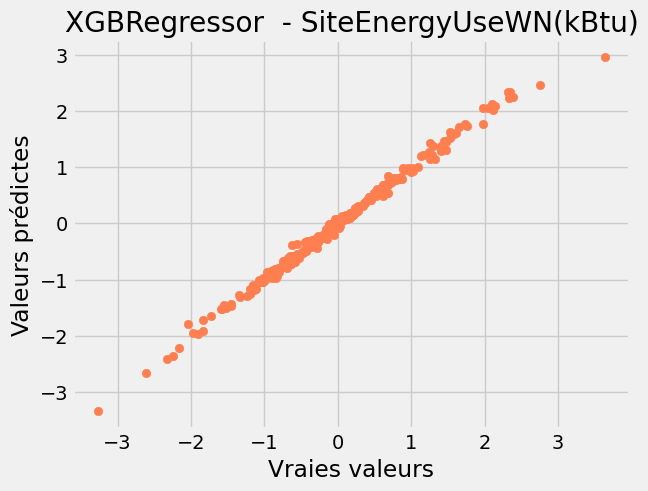

In [91]:
plt.title("XGBRegressor  - SiteEnergyUseWN(kBtu)")
plt.scatter(y_test, y_xgb_pred, color='coral')
plt.xlabel("Vraies valeurs")
plt.ylabel("Valeurs prédictes")

## Tableau recapitulatif des quatres modeles

linéaire
RMSE: 0.51
Coefficient of determination (R²): 0.75

LSVR
RMSE: 0.68
Coefficient of determination (R²): 0.55

Random Forest
RMSE: 0.34
Coefficient of determination (R²): 0.89

XGBoost
RMSE: 0.07
Coefficient of determination (R²): 0.99

### Test des hypothèses

## MODELE RETENU ET PREDICTIONS

D'Après les analyses, le modèle XGBoost donne le meilleur compromis de performance.
En effet, il est meilleur en terme de score r2 0.99 et également meilleur en terme de score RMSE 0.07. Par conséquent nous 


### MODELE XGBoost

C’est une méthode ensembliste qui fait partie de la famille des algorithmes de boosting qui se base sur les arbres de décision et qui utilise plus particulièrement le boosting de gradient.

Cet algorithme construit un modèle faible qui donne de très mauvais résultats, il tire des conclusions sur les erreurs qui existent entre la prédiction et la réalité. A partir de ces conclusions et des conditions prises lors de la création du premier arbre, il va construire un modèle plus solide en tentant de

In [126]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from datetime import datetime
start_time = datetime.now()

# On fixe les valeurs des hyperparamètres à tester
param_grid = {'n_estimators':  [5, 100, 200],  
              'max_depth': [20,50,5],
              'learning_rate': [0.02, 0.05, 0.1],
              'gamma': [0.5, 1, 3],
            'min_child_weight': [1, 3, 5],
             }
                
# Choisir un score à optimiser
score = 'r2'

# define the model/ estimator
model = XGBRegressor(random_state=42, verbosity = 0) 
# On utilise GridSearchCV
xgbr= GridSearchCV(model, param_grid, scoring=score, cv=5)   

# On optimise sur le jeu d'entraînement
xgbr.fit(X_train, y_train)

# On généralise
y_xgbr = xgbr.predict(X_test)

# Afficher le(s) hyperparamètre(s) optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
print(xgbr.best_params_)
print(' ')
print("Meilleur(s) score sur le jeu d'entraînement:")
print(xgbr.best_score_)
print(' ')



Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'gamma': 0.5, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 200}
 
Meilleur(s) score sur le jeu d'entraînement:
0.991591897088216
 


In [127]:
#RMSE
print("RMSE: %.3f" % np.sqrt(mean_squared_error(y_test, y_xgbr)))
print(' ')
# Afficher les performances correspondantes
print("Résultats de la validation croisée :")


RMSE: 0.102
 
Résultats de la validation croisée :


In [128]:
for mean, std, params in zip(
        xgbr.cv_results_['mean_test_score'], # score moyen
        xgbr.cv_results_['std_test_score'],  # écart-type du score
        xgbr.cv_results_['params']           # valeur de l'hyperparamètre
    ):

    print("{} = {:.3f} (+/-{:.03f}) for {}".format(
        score,
        mean,
        std*2,
        params
    ) )
end_time = datetime.now()
print('Durée d\'exécution : {}'.format(end_time - start_time))

r2 = 0.168 (+/-0.013) for {'gamma': 0.5, 'learning_rate': 0.02, 'max_depth': 20, 'min_child_weight': 1, 'n_estimators': 5}
r2 = 0.966 (+/-0.018) for {'gamma': 0.5, 'learning_rate': 0.02, 'max_depth': 20, 'min_child_weight': 1, 'n_estimators': 100}
r2 = 0.991 (+/-0.012) for {'gamma': 0.5, 'learning_rate': 0.02, 'max_depth': 20, 'min_child_weight': 1, 'n_estimators': 200}
r2 = 0.168 (+/-0.013) for {'gamma': 0.5, 'learning_rate': 0.02, 'max_depth': 20, 'min_child_weight': 3, 'n_estimators': 5}
r2 = 0.966 (+/-0.018) for {'gamma': 0.5, 'learning_rate': 0.02, 'max_depth': 20, 'min_child_weight': 3, 'n_estimators': 100}
r2 = 0.991 (+/-0.012) for {'gamma': 0.5, 'learning_rate': 0.02, 'max_depth': 20, 'min_child_weight': 3, 'n_estimators': 200}
r2 = 0.168 (+/-0.013) for {'gamma': 0.5, 'learning_rate': 0.02, 'max_depth': 20, 'min_child_weight': 5, 'n_estimators': 5}
r2 = 0.967 (+/-0.018) for {'gamma': 0.5, 'learning_rate': 0.02, 'max_depth': 20, 'min_child_weight': 5, 'n_estimators': 100}
r2 = 0

### FEATURE IMPORTANCE

NameError: name 'best_ridge_model' is not defined

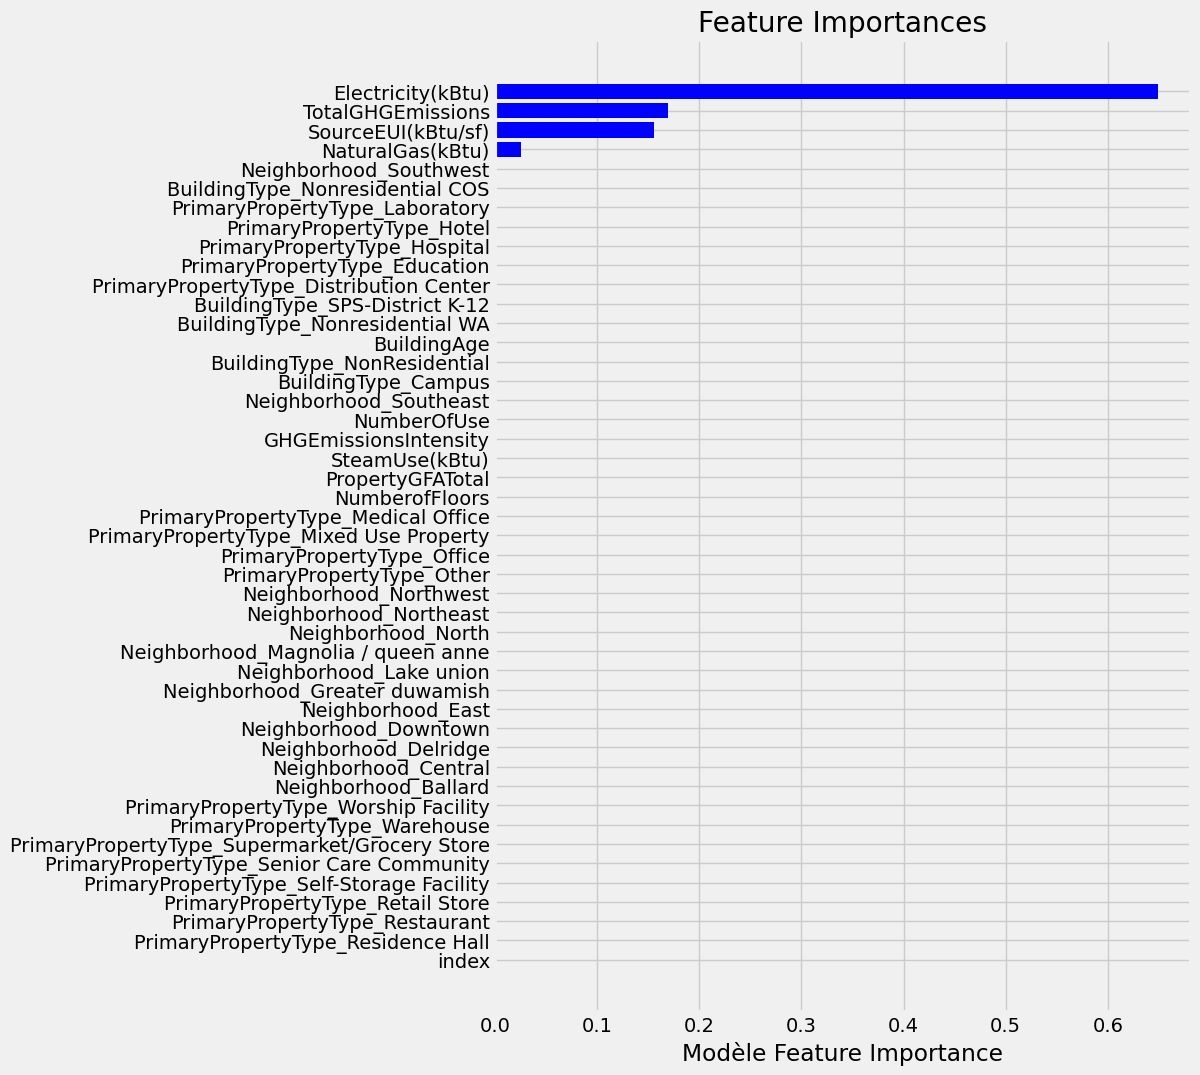

In [130]:
liste_variables=X_test.columns
importances = xgbr.best_estimator_.feature_importances_
indices = np.argsort(importances)

# style du graphique 
plt.figure(figsize=(8,12))
plt.style.use('fivethirtyeight')
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [liste_variables[i] for i in indices])
plt.xlabel("Modèle Feature Importance")

df_feature_importance = pd.DataFrame(best_ridge_model.coef_, columns=["coef"], index=grid_search.feature_names_in_)
print(f"Shape: {df_feature_importance.shape}")
df_feature_importance.head()

## predictions "SiteEnergyUse(kBtu)"

In [131]:
# Obtention des prédictions et des métriques d'évaluation
y_train_pred = lr_model.predict(sm.add_constant(X_train))
y_test_pred = lr_model.predict(sm.add_constant(X_test))
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_train = np.sqrt(mse_train)
rmse_test = np.sqrt(mse_test)

In [132]:
# Construction du tableau de résultats

df_metrics = pd.DataFrame({
    'Métrique': ['R2', 'MSE', 'RMSE'],
    'Train': [r2_train, mse_train, rmse_train],
    'Test': [r2_test, mse_test, rmse_test]
})

print(df_metrics)

  Métrique     Train      Test
0       R2  0.761514  0.750081
1      MSE  0.236393  0.258679
2     RMSE  0.486203  0.508605


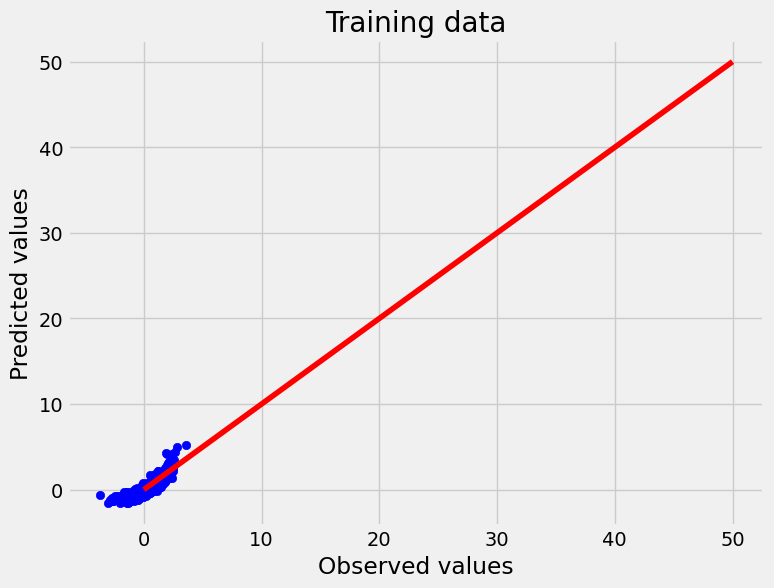

In [133]:
# Tracer les valeurs observées en fonction des valeurs prédites sur les données d'entraînement
plt.figure(figsize=(8, 6))
plt.scatter(y_train, y_train_pred, color='blue')
plt.xlabel('Observed values')
plt.ylabel('Predicted values')
plt.title('Training data')
plt.plot(np.arange(0, 55, 5), np.arange(0, 55, 5), color='red')
plt.show()



### ANALYSE DU MODELE RETENU DANS LE CAS DE L'INTRODUCTION DE LA VARIABLE "ENERGYSTARScore"

### MODELE AVEC INSERTION DE LA VARIABLE ENERGIE ENERGYSTARScore 

In [96]:
data_cleaned = pd.read_csv(Path(DATA_DIR, "data_cleaned.csv"))

In [97]:
col_num_1 = data_cleaned.select_dtypes(['int64','float64']).columns
col_num_1

Index(['Unnamed: 0', 'OSEBuildingID', 'YearBuilt', 'NumberofBuildings',
       'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
       'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA',
       'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA',
       'ENERGYSTARScore', 'SourceEUI(kBtu/sf)', 'SiteEnergyUse(kBtu)',
       'SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)',
       'TotalGHGEmissions', 'GHGEmissionsIntensity', 'NumberOfUse',
       'BuildingAge', 'SiteEnergyUse(log(kBtu))'],
      dtype='object')

In [98]:
Var_cat_1=data_cleaned.select_dtypes(['object']).columns
Var_cat_1

Index(['BuildingType', 'PrimaryPropertyType', 'Neighborhood',
       'LargestPropertyUseType', 'SecondLargestPropertyUseType',
       'ThirdLargestPropertyUseType', 'ComplianceStatus', 'Outlier'],
      dtype='object')

In [102]:
var_norm_1=[ 'NumberofFloors', 'PropertyGFATotal',
       'SourceEUI(kBtu/sf)', 'SteamUse(kBtu)',
       'Electricity(kBtu)', 'NaturalGas(kBtu)', 'TotalGHGEmissions',
       'GHGEmissionsIntensity', 'NumberOfUse', 'BuildingAge',
       'SiteEnergyUse(log(kBtu))', 'ENERGYSTARScore']
var_cat_1=['BuildingType', 'PrimaryPropertyType', 'Neighborhood']

In [103]:
data_mod_1=data_cleaned[['NumberofFloors', 'PropertyGFATotal',
       'SourceEUI(kBtu/sf)', 'SteamUse(kBtu)',
       'Electricity(kBtu)', 'NaturalGas(kBtu)', 'TotalGHGEmissions',
       'GHGEmissionsIntensity', 'NumberOfUse', 'BuildingAge',
       'SiteEnergyUse(log(kBtu))','BuildingType', 'PrimaryPropertyType', 'Neighborhood','ENERGYSTARScore']]

In [104]:
# standardisation des variables numériques
data_mod_1[var_norm_1] = StandardScaler().fit_transform(data_mod_1[var_norm_1])

C:\Users\HP\AppData\Local\Temp\ipykernel_3368\3482696685.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_mod_1[var_norm_1] = StandardScaler().fit_transform(data_mod_1[var_norm_1])


In [105]:
var_norm_1

['NumberofFloors',
 'PropertyGFATotal',
 'SourceEUI(kBtu/sf)',
 'SteamUse(kBtu)',
 'Electricity(kBtu)',
 'NaturalGas(kBtu)',
 'TotalGHGEmissions',
 'GHGEmissionsIntensity',
 'NumberOfUse',
 'BuildingAge',
 'SiteEnergyUse(log(kBtu))',
 'ENERGYSTARScore']

In [106]:
# reccupération des variables Catégorielles
col_cat = data_mod_1.select_dtypes(['object']).columns

In [107]:
 #Création d'une instance one-hot-encoder
encoder= OneHotEncoder(handle_unknown='ignore')

# Effectuer un one-hot encoding sur les colonnes 'col_cat'
data_ohe = pd.DataFrame(encoder.fit_transform(data_mod_1[col_cat]).toarray())

# Obtenez les noms des caractéristiques pour les colonnes one-hot encodées
feature_names = encoder.get_feature_names_out(input_features=col_cat)
data_ohe.columns = feature_names

# Fusionner les colonnes one-hot encoded avec le DataFrame d'origine
data_mod_encode = pd.merge(data_mod_1[col_num].reset_index(), data_ohe, left_index=True, right_index=True)

In [108]:
data_mod_encode

,index,NumberofFloors,PropertyGFATotal,SourceEUI(kBtu/sf),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity,NumberOfUse,...,Neighborhood_Downtown,Neighborhood_East,Neighborhood_Greater duwamish,Neighborhood_Lake union,Neighborhood_Magnolia / queen anne,Neighborhood_North,Neighborhood_Northeast,Neighborhood_Northwest,Neighborhood_Southeast,Neighborhood_Southwest
0,0,1.391058,-0.089255,0.033681,1.045306,-0.068894,-0.058085,0.341808,0.659356,-0.657886,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,1.218161,0.001653,0.000434,-0.135340,-0.129545,0.700881,0.477402,0.674224,0.966446,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,6.405090,5.123454,0.342247,12.571236,3.862555,-0.015445,5.777713,0.342162,-0.657886,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,1.045263,-0.252147,0.208742,1.169366,-0.170422,0.046827,0.449533,1.571287,-0.657886,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,-0.337918,-0.036063,0.728733,-0.135340,0.226556,0.616541,0.494987,0.793172,-0.657886,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1290,1290,-0.510816,-0.546679,-0.074369,-0.135340,-0.364030,-0.244652,-0.335102,0.099311,-0.657886,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1291,1291,-0.510816,-0.524415,-0.321118,-0.135340,-0.375046,-0.199872,-0.301913,0.252951,-0.657886,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1292,1292,-0.510816,-0.541494,2.954668,-0.135340,-0.254671,0.471081,0.263666,7.677265,0.966446,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1293,1293,-0.510816,-0.535823,-0.367351,-0.135340,-0.379158,-0.235799,-0.331644,0.034881,2.590779,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## CHOIX DU MODELE DE REGRESSION

In [109]:
# Division les données de data_cleaned_encode en ensembles d'apprentissage et de test

train, test = train_test_split(data_mod_encode, test_size=0.2, random_state=42)
print("Entrainement: {} lignes,\nTest: {} lignes.\n".format(train.shape[0],
                                                            test.shape[0]))


Entrainement: 1036 lignes,
Test: 259 lignes.



In [110]:
## MODELISATION SUR LA BASE TRAIN

In [112]:
lr = LinearRegression()
lsvr = LinearSVR(random_state=42, tol=1e-05)
clf = RandomForestRegressor(max_depth=2, random_state=42)
import xgboost as xgb
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor

# Utilisez un autre nom de variable pour le modèle XGBRegressor
xgb = xgb.XGBRegressor(objective="reg:linear", random_state=42)


xgb = XGBRegressor(max_depth=2,random_state=42)

In [113]:
### 1. Modèle de Regression Lineaire

In [114]:
import statsmodels.api as sm
# Séparation des variables prédictives et de la variable cible
X_train = train.drop("SiteEnergyUse(log(kBtu))", axis=1)
y_train = train["SiteEnergyUse(log(kBtu))"]


X_test = test.drop("SiteEnergyUse(log(kBtu))", axis=1)
y_test = test["SiteEnergyUse(log(kBtu))"]

# Fit du modèle linéaire
lr_model = sm.OLS(y_train, sm.add_constant(X_train)).fit()

# Obtention du tableau de résultats
results_table = lr_model.summary2().tables[1]
results_table

,Coef.,Std.Err.,t,P>|t|,[0.025,0.975]
const,0.398366,0.094059,4.235271,2.495015e-05,0.213788,0.582943
index,-0.000531,0.000048,-11.176473,2.127972e-27,-0.000624,-0.000438
NumberofFloors,-0.026434,0.028828,-0.916982,3.593749e-01,-0.083004,0.030136
PropertyGFATotal,0.394273,0.036435,10.821278,7.119762e-26,0.322774,0.465771
SourceEUI(kBtu/sf),0.289844,0.030369,9.544068,1.030067e-20,0.230249,0.349439
SteamUse(kBtu),405.352762,709.554870,0.571278,5.679409e-01,-987.048096,1797.753620
Electricity(kBtu),250.139037,437.758556,0.571409,5.678521e-01,-608.900079,1109.178153
NaturalGas(kBtu),837.591864,1466.209398,0.571263,5.679505e-01,-2039.636255,3714.819983
TotalGHGEmissions,-1046.831014,1832.591884,-0.571230,5.679733e-01,-4643.032831,2549.370803
GHGEmissionsIntensity,0.216685,0.025288,8.568790,3.956481e-17,0.167061,0.266308


In [115]:
lr.fit(X_train, y_train)
y_lr_pred = lr.predict(X_test)
print("RMSE: %.2f" % np.sqrt(mean_squared_error(y_test, y_lr_pred)))
print("Coefficient of determination (R²): %.2f"% r2_score(y_test, y_lr_pred))

RMSE: 0.51
Coefficient of determination (R²): 0.75


In [116]:
## 2. Algorithme LinearSVR

In [117]:
lsvr.fit(X_train, y_train)
y_lsvr_pred = lsvr.predict(X_test)
print("RMSE: %.2f" % np.sqrt(mean_squared_error(y_test, y_lsvr_pred)))
print("Coefficient of determination (R²): %.2f"% r2_score(y_test, y_lsvr_pred))

RMSE: 0.68
Coefficient of determination (R²): 0.55


C:\Users\HP\anaconda3\lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\HP\anaconda3\lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Text(0, 0.5, 'Valeurs prédictes')

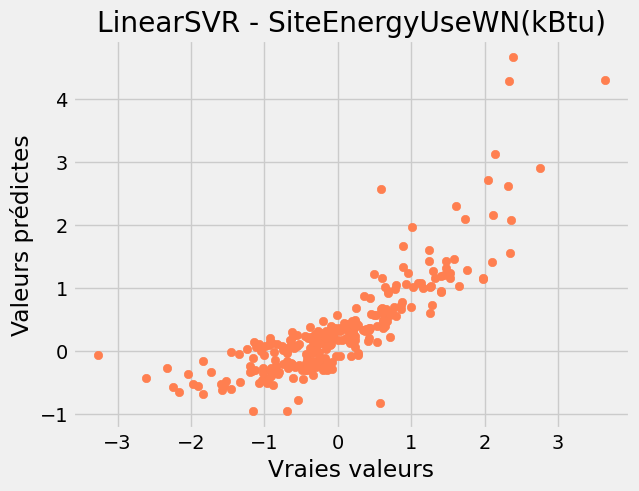

In [118]:
plt.title("LinearSVR - SiteEnergyUseWN(kBtu)")
plt.scatter(y_test, y_lsvr_pred, color='coral')
plt.xlabel("Vraies valeurs")
plt.ylabel("Valeurs prédictes")

In [119]:
## 3. Algorithme RandomForestRegressor

In [120]:
clf.fit(X_train, y_train)
y_rdf_pred = clf.predict(X_test)
print("RMSE: %.2f" % np.sqrt(mean_squared_error(y_test, y_rdf_pred)))
print("Coefficient of determination (R²): %.2f"% r2_score(y_test, y_rdf_pred))

RMSE: 0.40
Coefficient of determination (R²): 0.84


Text(0, 0.5, 'Valeurs prédictes')

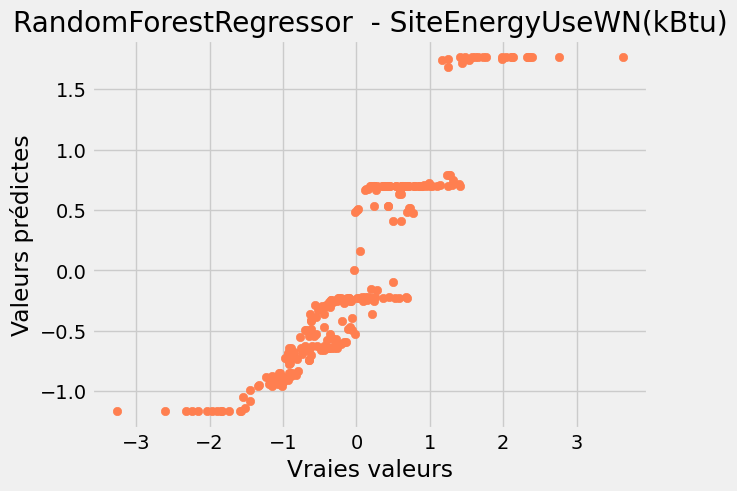

In [121]:
plt.title("RandomForestRegressor  - SiteEnergyUseWN(kBtu)")
plt.scatter(y_test, y_rdf_pred, color='coral')
plt.xlabel("Vraies valeurs")
plt.ylabel("Valeurs prédictes")

In [122]:
## 4.Algorithme XGBoost

In [123]:
xgb.fit(X_train, y_train)
y_xgb_pred = xgb.predict(X_test)
print("RMSE: %.2f" % np.sqrt(mean_squared_error(y_test, y_xgb_pred)))
print("Coefficient of determination (R²): %.2f"% r2_score(y_test, y_xgb_pred))

RMSE: 0.08
Coefficient of determination (R²): 0.99


Text(0, 0.5, 'Valeurs prédictes')

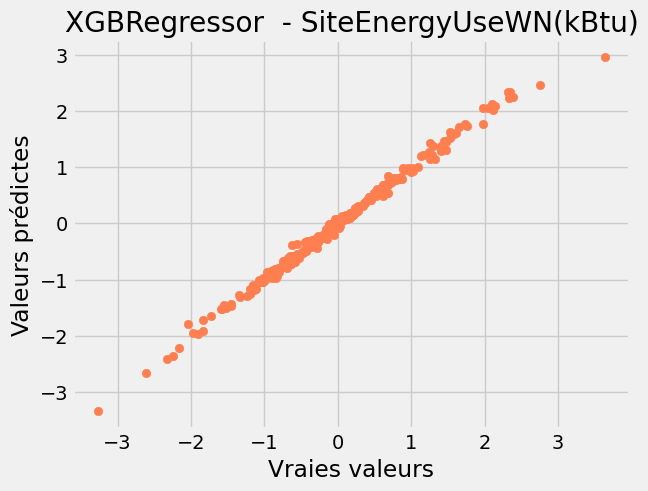

In [124]:
plt.title("XGBRegressor  - SiteEnergyUseWN(kBtu)")
plt.scatter(y_test, y_xgb_pred, color='coral')
plt.xlabel("Vraies valeurs")
plt.ylabel("Valeurs prédictes")

In [125]:
## Tableau recapitulatif des quatres modeles

In [ ]:
linéaire
RMSE: 0.51
Coefficient of determination (R²): 0.75
LSVR
RMSE: 0.68
Coefficient of determination (R²): 0.55

Random Forest
RMSE: 0.34
Coefficient of determination (R²): 0.89

XGBoost
RMSE: 0.07
Coefficient of determination (R²): 0.99

In [ ]:
### MODELE XGBoost

In [ ]:
C’est une méthode ensembliste qui fait partie de la famille des algorithmes de boosting qui se base sur les arbres de décision et qui utilise plus particulièrement le boosting de gradient.

Cet algorithme construit un modèle faible qui donne de très mauvais résultats, il tire des conclusions sur les erreurs qui existent entre la prédiction et la réalité. A partir de ces conclusions et des conditions prises lors de la création du premier arbre, il va construire un modèle plus solide en tentant de

In [ ]:
#RMSE
print("RMSE: %.3f" % np.sqrt(mean_squared_error(y_test, y_xgbr)))
print(' ')
# Afficher les performances correspondantes
print("Résultats de la validation croisée :")


In [ ]:
for mean, std, params in zip(
        xgbr.cv_results_['mean_test_score'], # score moyen
        xgbr.cv_results_['std_test_score'],  # écart-type du score
        xgbr.cv_results_['params']           # valeur de l'hyperparamètre
    ):

    print("{} = {:.3f} (+/-{:.03f}) for {}".format(
        score,
        mean,
        std*2,
        params
    ) )
end_time = datetime.now()
print('Durée d\'exécution 

In [ ]:
## predictions "SiteEnergyUse(kBtu)"